In [1]:
import os, cv2, math, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
path = "train_zip\\orange_images"                      #Path to the folder where there are images
annot = "train_zip\\orange_annotations"                #Path to the folder where there are csv files (info for boxes)

orange_5.jpg


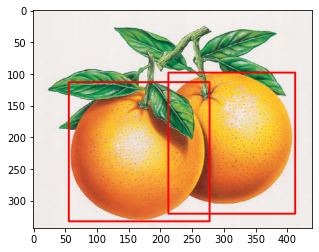

In [3]:
#Visualization of data
i = "orange_5.csv"                                      # .csv file has information regarding the corodinates of box
filename = i.split(".")[0] + ".jpg"
print(filename)
image = cv2.imread(os.path.join(path, filename)) 
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)          #switching the color channel from bgr to rgb
df = pd.read_csv(os.path.join(annot,i))
# plt.imshow(image)
for row in df.iterrows():
    x1 = int(row[1][0].split(" ")[0])
    y1 = int(row[1][0].split(" ")[1])
    x2 = int(row[1][0].split(" ")[2])
    y2 = int(row[1][0].split(" ")[3])
    cv2.rectangle(image,(x1,y1),(x2,y2),(255,0,0), 2)   #Adding the rectangle to the image
# plt.figure()
plt.imshow(image)

(831, 4)


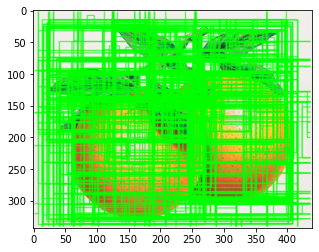

In [4]:
#Visulaization of selective search
cv2.setUseOptimized(True)
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
im = cv2.imread(os.path.join(path,"orange_5.jpg"))
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)          
ss.setBaseImage(im)
ss.switchToSelectiveSearchFast()
rects = ss.process()
print(rects.shape)
imOut = im.copy()
for i, rect in (enumerate(rects)):
    x, y, w, h = rect
    #     print(x,y,w,h)
    #     imOut = imOut[x:x+w,y:y+h]
    cv2.rectangle(imOut, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
# plt.figure()
plt.imshow(imOut)

In [5]:
train_images=[]
train_labels=[]

In [6]:
def get_iou(bb1, bb2):
    '''
    Calculates Intersection over Union (IoU) for the proposals generated from selective search
    '''
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']

    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])

    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [7]:
#Performing selective search on each image in our data set
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
for e,i in enumerate(os.listdir(annot)):
    if i.startswith("orange"):              #Only viewing files which starts with word "orange"
        filename = i.split(".")[0]+".jpg"
        print(e,filename)                   #Printing the number on which selective search is processing
        image = cv2.imread(os.path.join(path,filename))
        df = pd.read_csv(os.path.join(annot,i))
        gtvalues=[]
        for row in df.iterrows():
            x1 = int(row[1][0].split(" ")[0])
            y1 = int(row[1][0].split(" ")[1])
            x2 = int(row[1][0].split(" ")[2])
            y2 = int(row[1][0].split(" ")[3])
            gtvalues.append({"x1":x1,"x2":x2,"y1":y1,"y2":y2})
        ss.setBaseImage(image)
        ss.switchToSelectiveSearchFast()
        ssresults = ss.process()
        imout = image.copy()
        counter = 0
        falsecounter = 0
        flag = 0
        fflag = 0
        bflag = 0
        for e,result in enumerate(ssresults):
            if e < 2000 and flag == 0:
                for gtval in gtvalues:
                    x,y,w,h = result
                    iou = get_iou(gtval,{"x1":x,"x2":x+w,"y1":y,"y2":y+h})
                    if counter < 30:           #For a image maximum number of positive region we are taking is 30
                        if iou > 0.70:         # Criteria we set for a region to be called Positive
                            timage = imout[y:y+h,x:x+w]
                            resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                            train_images.append(resized)
                            train_labels.append(0)
                            counter += 1
                    else :
                        fflag =1
                    if falsecounter <30:          #For a image maximum number of false region we are taking is 30
                        if iou < 0.3:             # Criteria we set for a region to be called negative
                            timage = imout[y:y+h,x:x+w]
                            resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                            train_images.append(resized)
                            train_labels.append(1)
                            falsecounter += 1
                    else :
                        bflag = 1
                if fflag == 1 and bflag == 1:
                    print("inside")           # If for an image we find 30 positive and 30 negative regions we display
                    flag = 1

0 orange_1.jpg
1 orange_10.jpg
2 orange_11.jpg
3 orange_12.jpg
4 orange_13.jpg
inside
5 orange_14.jpg
inside
6 orange_15.jpg
7 orange_16.jpg
inside
8 orange_17.jpg
9 orange_18.jpg
10 orange_19.jpg
11 orange_2.jpg
inside
12 orange_20.jpg
13 orange_21.jpg
14 orange_22.jpg
15 orange_23.jpg
16 orange_24.jpg
17 orange_25.jpg
18 orange_26.jpg
19 orange_27.jpg
20 orange_28.jpg
inside
21 orange_29.jpg
22 orange_3.jpg
inside
23 orange_30.jpg
inside
24 orange_31.jpg
25 orange_32.jpg
26 orange_33.jpg
27 orange_34.jpg
28 orange_35.jpg
29 orange_36.jpg
30 orange_37.jpg
31 orange_38.jpg
32 orange_4.jpg
33 orange_40.jpg
34 orange_41.jpg
35 orange_42.jpg
36 orange_43.jpg
37 orange_44.jpg
38 orange_46.jpg
inside
39 orange_47.jpg
40 orange_48.jpg
41 orange_49.jpg
42 orange_5.jpg
43 orange_50.jpg
44 orange_51.jpg
45 orange_52.jpg
46 orange_53.jpg
inside
47 orange_54.jpg
48 orange_55.jpg
49 orange_56.jpg
50 orange_57.jpg
51 orange_58.jpg
52 orange_59.jpg
53 orange_6.jpg
54 orange_60.jpg
inside
55 orange_6

In [8]:
def rgb2gray(rgb):
    '''
    Converts a given image in rgb to grayscale
    '''
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

In [9]:
#Converting images to grayscale
#Resize images to (64,64)
for i in range(len(train_images)):
    train_images[i] = rgb2gray(train_images[i])
    train_images[i] = cv2.resize(train_images[i], (64,64), interpolation = cv2.INTER_AREA)
    
X_new = np.array(train_images)
Y_new = np.array(train_labels)

#Splitting the Dataset to train and test
from sklearn.model_selection import train_test_split
xTrain, xTest, yTrain, yTest = train_test_split(X_new, Y_new, test_size = 0.2, random_state = 0)
print("Input Shape:", xTrain.shape)

Input Shape: (2679, 64, 64)


In [10]:
def dot(A,X):
    ans = np.zeros((len(A),len(X[0])))
    for i in range(len(A)):
        for j in range(len(X[0])):
            for k in range(len(X)):
                ans[i][j] = ans[i][j] + A[i][k]*X[k][j]
    return ans

In [11]:
class conv_op:
    def __init__(self, num_filters, filter_size):
        self.num_filters = num_filters
        self.filter_size = filter_size
        self.conv_filter = np.random.randn(num_filters, filter_size, filter_size)/(filter_size**2)
        
    def image_region(self, image):
        height, width = image.shape
        self.image = image
        for j in range(height - self.filter_size + 1):
            for k in range(width - self.filter_size + 1):
                image_patch = image[j:(j+self.filter_size), k: (k+self.filter_size)]
                yield image_patch, j, k
    
    def forward_prop(self, image):
        height, width = image.shape
        conv_out = np.zeros((height - self.filter_size + 1, width - self.filter_size + 1, self.num_filters))
        for image_patch, i, j in self.image_region(image):
            count = 0
            conv_out[i, j] = np.sum(image_patch*self.conv_filter, axis=(1,2))
        return conv_out
    
    def back_prop(self, dl_out, learning_rate):
        dl_df_params = np.zeros(self.conv_filter.shape)
        for image_patch, i, j in self.image_region(self.image):
            for k in range(self.num_filters):
                dl_df_params[k] += image_patch*dl_out[i,j,k]
                
        self.conv_filter -= learning_rate*dl_df_params
        return dl_df_params

In [12]:
class Max_Pool:
    def __init__(self, filter_size):
        self.filter_size = filter_size
        
    def image_region(self, image):
        new_height = image.shape[0]//self.filter_size
        new_width = image.shape[1]//self.filter_size
        self.image = image
        
        for i in range(new_height):
            for j in range(new_width):
                image_patch = image[(i*self.filter_size):(i*self.filter_size + self.filter_size), (j*self.filter_size): (j*self.filter_size+self.filter_size)]
                yield image_patch, i, j
                
    def forward_prop(self, image):
        height, width, num_filters = image.shape
        output = np.zeros((height//self.filter_size, width//self.filter_size, num_filters))
        
        for image_patch, i, j in self.image_region(image):
            output[i,j] = np.amax(image_patch, axis = (0,1))
            
        return output
    
    def back_prop(self, dl_dout):
        dl_dmaxpool = np.zeros(self.image.shape)
        for image_patch, i, j in self.image_region(self.image):
            height, width, num_filters = image_patch.shape
            maximum_val = np.amax(image_patch, axis = (0,1))
            
            for i1 in range(height):
                for j1 in range(width):
                    for k1 in range(num_filters):
                        if image_patch[i1,j1,k1] == maximum_val[k1]:
                            dl_dmaxpool[i*self.filter_size + i1, j*self.filter_size + j1, k1] = dl_dout[i,j,k1]
                            
        return dl_dmaxpool

In [13]:
class Softmax:
    def __init__(self, input_node, softmax_node):
        self.weight = np.random.randn(input_node, softmax_node)/input_node
        self.bias = np.zeros(softmax_node)
        
    def forward_prop(self,image):
        self.orig_im_shape = image.shape  #used in back prop
        image_modified = image.flatten()
        self.modified_input = image_modified #to be used in back prop
        output_val = np.dot(image_modified, self.weight) + self.bias
#         output_val = dot(image_modified, self.weight) + self.bias
        self.out = output_val
        exp_out = np.exp(output_val)
        return exp_out/np.sum(exp_out, axis = 0)
    
    def back_prop(self, dl_dout, learning_rate):
        for i, grad in enumerate(dl_dout):
            if grad == 0:
                continue
            
            transformation_eq = np.exp(self.out)
            S_total = np.sum(transformation_eq)
            
            #Gradients w.r.t out z
            dy_dz = -transformation_eq[i]*transformation_eq/(S_total**2)
            dy_dz[i] = transformation_eq[i]*(S_total - transformation_eq[i])/(S_total**2)
            
            #Gradients of weight, bias, input
            dz_dw = self.modified_input
            dz_db = 1
            dz_dinp = self.weight
            
            #Gradinets of loss agiants total
            dl_dz = grad*dy_dz
            
            #gradints of loss against weights/biases/input
            dl_dw = dz_dw[np.newaxis].T @ dl_dz[np.newaxis]
            dl_db = dl_dz*dz_db
            dl_dinp = dz_dinp @ dl_dz
            
            self.weight -= learning_rate*dl_dw
            self.bias -= learning_rate*dl_db
            return dl_dinp.reshape(self.orig_im_shape)

In [14]:
#Our Model Structure
conv = conv_op(12, 3)           #64x64x1 -> 62x62x12
pool = Max_Pool(8)              #62x62x12 -> 7x7x12
softmax = Softmax(7*7*12, 2)    #7x7x12 -> 2

In [15]:
def cnn_forward_prop(image, label):
    out_p = conv.forward_prop((image/255) - 0.5)
    out_p = pool.forward_prop(out_p)
    out_p = softmax.forward_prop(out_p)
    
    cross_ent_loss = -np.log(out_p[label])
    accuracy_eval = 1 if np.argmax(out_p) == label else 0
    return out_p, cross_ent_loss, accuracy_eval

In [16]:
def training_cnn(image, label, learning_rate=0.01):
    #Forward
    out, loss, acc = cnn_forward_prop(image, label)
    
    #calcaluate initial gradient
    gradient = np.zeros(2)
    gradient[label] = -1/out[label]
    
    #Backward
    grad_back = softmax.back_prop(gradient, learning_rate)
    grad_back = pool.back_prop(grad_back)
    grad_back = conv.back_prop(grad_back, learning_rate)
    
    return loss, acc

In [17]:
LOSS = []
SamplesTrained = []

In [18]:
#Training the Model
epoches = 5
for epoch in range(epoches):
    print(f'Epoch {epoch+1} ====>')
    #
    shuffle_data = np.random.permutation((len(xTrain)))
    final_images = xTrain[shuffle_data]
    final_labels = yTrain[shuffle_data]
    
    #Training th cnn
    loss = 0
    num_correct = 0
    for i, (im, label) in enumerate(zip(final_images,final_labels)):
        if i!=0 and i%100==0:
            LOSS.append(loss/100)
        if i%500== 0:
            print(f"{i+1} steps  Average Loss: {loss/500:.3} Accuracy: {num_correct/5}%")
            loss = 0
            num_correct = 0
        l, accu = training_cnn(im, label)
        loss+=l
        num_correct+=accu

Epoch 1 ====>
1 steps  Average Loss: 0.0 Accuracy: 0.0%
501 steps  Average Loss: 0.545 Accuracy: 73.0%
1001 steps  Average Loss: 0.433 Accuracy: 80.6%
1501 steps  Average Loss: 0.379 Accuracy: 84.2%
2001 steps  Average Loss: 0.409 Accuracy: 83.4%
2501 steps  Average Loss: 0.45 Accuracy: 80.0%
Epoch 2 ====>
1 steps  Average Loss: 0.0 Accuracy: 0.0%
501 steps  Average Loss: 0.391 Accuracy: 83.2%
1001 steps  Average Loss: 0.37 Accuracy: 83.4%
1501 steps  Average Loss: 0.342 Accuracy: 85.2%
2001 steps  Average Loss: 0.367 Accuracy: 85.4%
2501 steps  Average Loss: 0.442 Accuracy: 82.2%
Epoch 3 ====>
1 steps  Average Loss: 0.0 Accuracy: 0.0%
501 steps  Average Loss: 0.671 Accuracy: 84.6%
1001 steps  Average Loss: 1.42 Accuracy: 80.0%
1501 steps  Average Loss: 1.18 Accuracy: 82.0%
2001 steps  Average Loss: 0.557 Accuracy: 85.0%
2501 steps  Average Loss: 0.358 Accuracy: 87.4%
Epoch 4 ====>
1 steps  Average Loss: 0.0 Accuracy: 0.0%
501 steps  Average Loss: 0.382 Accuracy: 85.2%
1001 steps  Aver

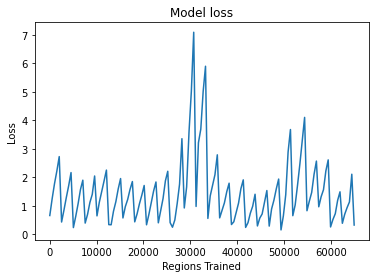

<Figure size 432x288 with 0 Axes>

In [19]:
LOSS = np.asarray(LOSS)
SamplesTrained = np.linspace(0,130*500,130)
# SamplesTrained.shape
# LOSS.shape
plt.plot(SamplesTrained, LOSS)
plt.xlabel("Regions Trained")
plt.title("Model loss")
plt.ylabel("Loss")
plt.show()
plt.savefig('scratchmodelloss.png')

In [20]:
#Testing the Model
loss = 0
num_correct = 0
for im, label in zip(xTest, yTest):
    _, l1, accu = cnn_forward_prop(im, label)
    loss+=l1
    num_correct += accu
    
num_tests = len(xTest)
print('Test Loss: ', loss/num_tests)
print('Test Accuracy: ', num_correct/num_tests)

Test Loss:  0.6496030508371969
Test Accuracy:  0.8119402985074626


In [21]:
def predict(image):
    out_p = conv.forward_prop((image/255) - 0.5)
    out_p = pool.forward_prop(out_p)
    out_p = softmax.forward_prop(out_p)
    
    return out_p

Probability that shape is orange: 0.9941955874514858
Probability that shape is not orange: 0.005804412548514102
Orange


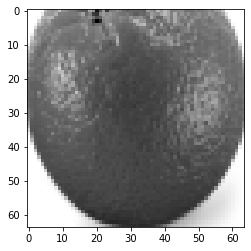

In [22]:
img = xTest[25]
plt.imshow(img, cmap='gray')
# print(img.shape)
# print(im.shape)
im = cv2.resize(im, (64,64), interpolation = cv2.INTER_AREA)
out= predict(img)
# print(out.shape)
print(f"Probability that shape is orange: {out[0]}")
print(f"Probability that shape is not orange: {out[1]}")
if out[0] > out[1]:
    print("Orange")
else:
    print("Not Orange")

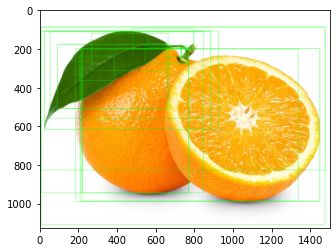

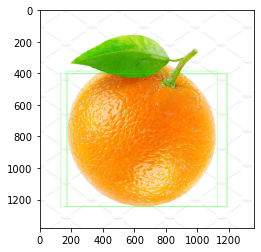

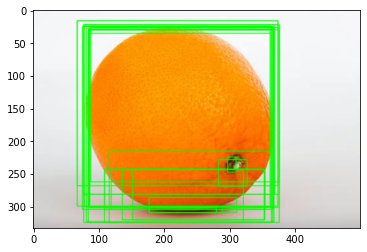

In [25]:
z=0
path = "orange_test"
for e,i in enumerate(os.listdir(path)):
    if i.startswith("orange"):
        z += 1
        img = cv2.imread(os.path.join(path,i))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ss.setBaseImage(img)
        ss.switchToSelectiveSearchFast()
        ssresults = ss.process()
        imout = img.copy()
        for e,result in enumerate(ssresults):
            if e < 2000:
                x,y,w,h = result
                timage = imout[y:y+h,x:x+w]
                resized = cv2.resize(timage, (64,64), interpolation = cv2.INTER_AREA)
                resized = rgb2gray(resized)
#                 predict(resized)
                out= predict(resized)
#                 print(out[0], out[1])
                if out[0] > 0.6:
                    cv2.rectangle(imout, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
        plt.figure()
        plt.imshow(imout)